In [4]:
#!pip3 install opencv-python
#!pip install pafy -U
#!pip install youtube_dl

In [5]:
#!pip install ipydagred3
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#

# ImageWidget

In [6]:
import cv2
import numpy as np
from PIL import Image
import io

style = {'description_width': '250px'}
layout = {'width': '500px'}

class ImageWidget(object):
    def __init__(self, image=None, display=True):
        self.count = 0
        
        self.image_w = widgets.Image(format='PNG')
        self.update_w = widgets.Checkbox(description='update',value=True)
        self.counter_w = widgets.Text(description = 'count',value = '', style=style, layout=layout,disabled=False)
        VBox      = widgets.VBox([self.update_w,self.counter_w])  
        self.HBox = widgets.HBox([self.image_w, VBox])  
        
        self.setImage(image)
        if display == True:
            self.display()
    
    def display(self):
        #display(self.image_w)  
        display(self.HBox) 
    
    def getByteArray(self,image):    
        #return None
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    
    def evaluate(self, image=None):
        self.setImage(image)
        
    def _dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {}}
    
    def setImage(self,image):
        #print('ImageWidget')
        self.count += 1
        self.counter_w.value = str(self.count) 
        
        if self.update_w.value == False:
            return
        
        if image != None:
            try:
                #print('set image', type(image))
                if isinstance(image, dict):
                    image = image['image']
                self.image_w.value = self.getByteArray(image)    
            except Exception as exception: 
                print('Exception ImageWidget', str(exception))
            
    def getImage(self):
        return Image.open(io.BytesIO(self.image_w.value))

# Actions and Widgets 

## BaseAction

In [7]:
class BaseAction(object):
    
    def __init__(self):
        self.name = __class__.__name__
    
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self.__dict__}
    
    def merged_dict(self,parameters=None):
        old = dict()
        return {'class':old['class'],'parameters':{**old['parameters'],**parameters}}
    
    def merge(self,parameters={}):
        adict = {'class' : self.__class__.__name__, 'parameters' : {**self.__dict__, **parameters}}
        #adict = merged_dict(parameters)
        return eval(adict['class'])(**adict['parameters'])
    
    def _get_image(self,image):
        if isinstance(image, dict):
            return image['image']
        return image
    
    def _filename(self,filename=None,name=None):
        if name != None:
            return name + '_' + self.__class__.__name__ + '.json'
        if filename == None:
            return '_action_' + self.__class__.__name__ + '.json'
        return filename
    
    def save(self,filename=None,name=None):
        with open(self._filename(filename,name), 'w', encoding='utf-8') as f:
            json.dump(self.dict(), f, ensure_ascii=False, indent=4)    

    def load(self,filename=None,name=None):
        with open(self._filename(filename,name), 'r') as fp:
            file = json.load(fp)  
            return file          
        
   

## BaseWidget

In [8]:
class BaseWidget(object):
    def evaluate(self,image=None):
        return self.action.evaluate(image)
    
    def _get_image(self,image):
        if isinstance(image, dict):
            return image['image']
        return image  
    
     # write output    
    def output_result(self,update=True, result=None):
        if update == True:
            if(self.imageWidget != None):
                self.imageWidget.evaluate(result)    
                
    def get_result(self):
        if hasattr(self, 'result'):
            return self.result
        return None 

## TemplateAction

In [9]:
class TemplateAction(BaseAction):
    def __init__(self):
        pass
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
        return self.result

## TemplateWidget

In [10]:
class TemplateWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([])
        
        if action == None:
            action = TemplateAction()
            
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
        return self.result
            
    def myfunc(self,**kwargs):
        # kwargs is a dictionary.
        for k,v in kwargs.items():
             print ("%s = %s" % (k, v))
        if 'image' in kwargs.keys():
            print('found')        

## CropAction

In [11]:
# input: image, output cropped image
class CropAction(BaseAction):
    WORLD = 0
    NORMALIZED = 1
    # __init__ is a special method called whenever you try to make
    # an instance of a class. As you heard, it initializes the object.
    # Here, we'll initialize some of the data.
    #def __init__(self, image=None, size=None, min=[0.0,0.0], max=[1.0,1.0]):
    #def __init__(self,size=None, min=None, max=None,region=None,mode=WORLD):
    def __init__(self,size=None, min=[0,0], max=[1,1],region=None,mode=WORLD):    
        self.min    = min
        self.max    = max
        self.region = None
        self.size   = size
        self.mode   = mode
        
    def dict(self):
        # return self.toNormalized().super(CropAction,self).__init__().dict()
        #return self.toNormalized().dict()
        return super(CropAction, self.toNormalized()).dict()
        
    # Problem: + 1    
    def evaluate(self, image=None):
        image = self._get_image(image)
        
        if self.mode == self.WORLD:
            return {'image':image.crop(self._flat())}
        return {'image':image.crop(self.fromNormalized(self.flat(), size=image.size))}      
        
    def _flat(self):
        return (self.min[0],self.min[1],self.max[0] + 1,self.max[1] + 1)
    
    def flat(self):
        return (self.min[0],self.min[1],self.max[0],self.max[1])
    
    def normalizeValue(self, value, size):
        return float (value) / size

    def fromNormalizedValue(self, value,size):
        return int(value * size)

    def normalized(self):    
        #print(self.min, self.max, self.size)
        xmin = self.normalizeValue(self.min[0],self.size[0])
        ymin = self.normalizeValue(self.min[1],self.size[1])
        xmax = self.normalizeValue(self.max[0],self.size[0])
        ymax = self.normalizeValue(self.max[1],self.size[1])
        return (xmin,ymin,xmax,ymax)    

    def toNormalized(self):
        if self.mode == self.NORMALIZED:
            return self
        _norm = self.normalized()
        return CropAction(min=[_norm[0],_norm[1]], max=[_norm[2],_norm[3]], mode=self.NORMALIZED)
    
    def toWorld(self,size):
        if self.mode == self.WORLD:
            return self
        
       
        _world = self.fromNormalized(self.flat(),size=size)
        #print('CropAction',_world)
        return CropAction(min=[_world[0],_world[1]], max=[_world[2],_world[3]], size=size, mode=self.WORLD)
    
    def fromNormalized(self, values, size=None):    
        if size == None:
            size = self.size
             
        # init size to fix initMinMax problem --> is this really required
        self.size = size        
                
         
        xmin = self.fromNormalizedValue(values[0],size[0])
        ymin = self.fromNormalizedValue(values[1],size[1])
        xmax = self.fromNormalizedValue(values[2],size[0])
        ymax = self.fromNormalizedValue(values[3],size[1])
       
        return [xmin,ymin,xmax,ymax]
    
    def update(self, size=None):
        to = self.normalized()
        self.size = size
        self.min[0] = self.fromNormalizedValue(to[0],size[0])
        self.min[1] = self.fromNormalizedValue(to[1],size[1])
        self.max[0] = self.fromNormalizedValue(to[2],size[0]) 
        self.max[1] = self.fromNormalizedValue(to[3],size[1]) 

## DisplayWidget
action: VideoAction (uses only VideoAction)

In [12]:
class DisplayWidget(BaseWidget):
    def __init__(self, action=None, update=None):
        self.action       = action
        self.index        = 0  # for change --> last index
        self.image        = None
        self.update       = update
        
        if action != None:
            self.init(action)
        
        _max = 5
        layout2={'width': '300px'}
        self.imageselectw = widgets.IntSlider(value=self.index, min=0,max=_max,step=1, description='image',layout=layout)
        self.imageselectw.observe(self.on_value_change_imageselectw, 'value')
        self.next_image_button = widgets.Button(description='Next', disabled=False, tooltip='next image',style=style)
        self.next_image_button.on_click(self.on_next_image_button_clicked)  
        self.skipframes = widgets.Text(description   = 'skip frames',value = '10', style=style, layout=layout2)
        self.skipframes.on_submit(self.on_value_submit_skipframes)
        image_select_hbox = widgets.HBox([self.imageselectw,self.next_image_button,self.skipframes])
        self.hbox=image_select_hbox
        
        self.init(action)
        
    def init(self,action=None):
        if action != None:
            self.action = action
            self.index  = action.index
    
    def on_value_submit_skipframes(self,change):
        if self.action != None:
            self.action.skipframes = int(change.value)
        
    # select image slider
    def on_value_change_imageselectw(self,change):
        self.index = change['new']
        self.action.setIndex(change['new'])
        
        self.image = self.action.evaluate()['image']
        if self.update != None:
            self.update(self.image,update=True)
        
    def on_next_image_button_clicked(self,b):
        if self.action.index != self.index:
            #self.action = VideoAction(video=self.action.video,index=self.index)
            self.action.setIndex(self.index)
        self.action.skipframes = int(self.skipframes.value)
        self.image = self.action.evaluate()['image']
        if self.update != None:
            self.update(self.image,update=True)

## CropWidget

abhängig von parent und sources (speichert regions dort)

In [13]:
#display(DisplayWidget(action=_crop.videoAction,imageWidget=_imageWidget).hbox)
class CropWidget(BaseWidget):
    def __init__(self, action=None, videoAction=None ,parent=None, imageWidget=None, image=None):
        self.result       = None
        self.action       = action
        self.image        = image    # buffers image to be cropped
        self.parent       = parent
        
        self.imageWidget  = imageWidget # None or used to display result
        self.displayWidget = None       # TODO: remove
    
        self.update = True 
    
        # still needed ?
        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        self.regions = dict()
        self.regions['reset'] = cropNormalizedArea
    
        if image != None:
            action.size = image.size
    
        self.reset_button = widgets.Button(description='Reset', disabled=False, tooltip='reset all values',style=style)
        self.reset_button.on_click(self.on_reset_button_clicked)  

        self.crop_name = widgets.Text(description = 'name',value = '', style=style, layout=layout,disabled=False)
        self.crop_name.on_submit(self.on_value_submit_crop_name)
        self.crop_list = widgets.Dropdown(description='region',options=self.regions.keys())
        self.crop_list.observe(self.crop_list_on_change) 
        self.crop_bookmarks = widgets.HBox([self.crop_list, self.crop_name, self.reset_button])
        
        ##########################################################################    
    
        self.crop_size_x = widgets.Text(description = 'x',value = '', style=style, layout=layout,disabled=False)
        self.crop_size_y = widgets.Text(description = 'y',value = '', style=style, layout=layout,disabled=False)
        size_vbox   = widgets.VBox([self.crop_size_x, self.crop_size_y])    
        
        #self.cropx0 = self._IntSlider(description='x0',value=0)
        #self.cropx1 = self._IntSlider(description='x1')
        #self.cropx0 = widgets.IntSlider(value=0, step=1, description='x0',layout=layout)
        #self.cropx1 = widgets.IntSlider(value=0, step=1, description='x1',layout=layout)
        #self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        #self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        
        #self.crop_hbox_x = widgets.HBox([self.cropx0, self.cropx1])
        
        self.crop_hbox_x = widgets.HBox()
        self.crop_hbox_y = widgets.HBox()
        self._addIntCropSliders()
        
        vbox1 = widgets.VBox([self.crop_bookmarks,self.crop_hbox_x, self.crop_hbox_y])
        hbox  = widgets.HBox([vbox1, size_vbox])
        self.vbox   = widgets.VBox([hbox])
        
        # set size of image
        if action != None and videoAction != None:
            self._action_to_world(videoAction.stream.dimensions)
        
        if action != None and action.size != None:
            self.initMinMax(action.size,(0,0,action.size[0]-1,action.size[1]-1))
        
        
    ### SLIDER ############################################################    
    def _addIntCropSliders(self):
        self.cropx0 = self._IntSlider(description='x0')
        self.cropx1 = self._IntSlider(description='x1')
        self.cropx0.observe(self.on_value_change_crop_xmin, 'value')
        self.cropx1.observe(self.on_value_change_crop_xmax, 'value')
        self.crop_hbox_x.children = (self.cropx0,self.cropx1)
        
        self.cropy0 =  self._IntSlider(description='y0')
        self.cropy1 =  self._IntSlider(description='y1')
        self.cropy0.observe(self.on_value_change_crop_ymin, 'value')
        self.cropy1.observe(self.on_value_change_crop_ymax, 'value')
        self.crop_hbox_y.children = (self.cropy0,self.cropy1)
        
    def _FloatSlider(self,description='',value=0.0,layout=layout):
        return widgets.FloatSlider(value=value,description=description, min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
    
    def _IntSlider(self,description='',value=0,max=0,layout=layout):
        return widgets.IntSlider(value=value, max=max,step=1, description=description,layout=layout)    
        
        
    # Hilfsfunktion, es gibt nur eine VideoACtion    
    def _get_VideoAction(self):
        return self.displayWidget.action
        
    def _action_to_world(self,size):
        if(self.action.mode != self.action.WORLD):
            self.action = self.action.toWorld(size=size)    
        
    
        
    ##########################################################################       
        
    # INIT    ---> creates new action !!! sets parameters for widget, depends on other actions
    # VideoAction oder parent ??????
    
    #def init(self, action=None, parent=None):
    def init(self, action=None):    
        #self.parent = parent
        self.crop_list.options=action.sources.videos[action.id]['bookmarks'].keys()
        
        ## TODO: remove ------> outside
        if self.displayWidget != None:
            self.displayWidget.init(action) 
            
        self.initMinMax()
   
    def evaluate(self,image=None):
        # Achtung schreibt image auch in ImageWidget !!!!!!! Doppelt
        #print('CropWidget', 'evaluate')
        self.updateImage(image)
        return self.result
    
    # after image is updated ######### size or image changed / source
    # called e.g. by DisplayWidget
    def updateImage(self,image=None,update=False):
        self.image = self._get_image(image)
        size = self.image.size
        
        if(self.action == None):
            self.action   = CropAction(size=size,min=[0,0], max=[size[0],size[1]])
        
       
        # action is normalized until size of image is known    
        self._action_to_world(size)
          
        if(self.action.size != size or self.cropx1.max != (size[0] - 1)):
            self.action.update(size)
            self.crop_image()
            self.initMinMax()
        else:
            self.crop_image(update=update)  
            
        self.crop_size_x.value = str(self.action.max[0] - self.action.min[0])
        self.crop_size_y.value = str(self.action.max[1] - self.action.min[1])
     
    # RESULT 
    def crop_image(self, update=False):
        image=None
        
        if self.image != None :  
            image = self.image
        elif self.parent != None:
            image = self.parent.get_result()
        
        if image != None:
            if(self.action == None):
                self.action   = CropAction(size=image.size,min=[0,0], max=[image.size[0],image.size[1]])
            
            self.result = self.action.evaluate(image=image)
            
            # write output
            if self.update == True:
                self.output_result(update=update,result=self.result)
                
            #if update == True:
            #    if(self.imageWidget != None):
            #        self.imageWidget.evaluate(self.result['image'])           
        
    def initMinMax(self,size=None,cropArea = None):
        print('CropWidget','initMinMax')
        if self.action == None:
            return
        
        if size == None:
            size = self.action.size
            self._action_to_world(size)
            cropArea = self.action.flat()
        else:
            self._action_to_world(size)
        
        self.update = False
        
        self.cropx0.max = size[0] - 1
        self.cropx1.max = size[0] - 1
        self.cropy0.max = size[1] - 1
        self.cropy1.max = size[1] - 1

        self.cropx0.value = cropArea[0]
        self.cropy0.value = cropArea[1]
        self.cropx1.value = cropArea[2]
        
        # update image only once
        self.update = True
        self.cropy1.value = cropArea[3]    
        
    def on_value_change_crop_xmin(self,change):
        self.cropx1.min  = change['new']
        self.action.min[0] = change['new']
        self.crop_image(update=True)
            
    def on_value_change_crop_xmax(self,change):
        self.cropx0.max  = change['new']
        self.action.max[0] = change['new']
        self.crop_image(update=True)

    def on_value_change_crop_ymin(self,change):
        self.cropy1.min  = change['new']
        self.action.min[1] = change['new']
        self.crop_image(update=True)

    def on_value_change_crop_ymax(self,change):
        self.cropy0.max  = change['new']
        self.action.max[1] = change['new']
        self.crop_image(update=True)        
        
        
        
    # add/update bookmark of current video source
    def add_bookmark(self,name):
        self._get_VideoAction().sources.videos[self._get_VideoAction().id]['bookmarks'][name] = self.action.normalized()
        
        if name not in self.crop_list.options:
            self.crop_list.options = list(self.crop_list.options) + [name] 
        self.crop_list.value = name
    
    def remove_bookmark(self,name):
        del(self._get_VideoAction().sources.videos[self._get_VideoAction().id]['bookmarks'][name])
        
        _list = list(self.crop_list.options)
        if 'test3' in _list: _list.remove('test3')
        self.crop_list.options = _list
        self.crop_list.value = _list[len(_list)-1]
    
    def on_value_submit_crop_name(self,change):
        self.add_bookmark(change.value)
        
    def crop_list_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.crop_name.value = change['new']
            #self.initMinMax(self.action.size,self.action.fromNormalized(self.parent.sources.videos[self.displayWidget.action.id]['bookmarks'][change['new']]))
            self.initMinMax(self.action.size,self.action.fromNormalized(self._get_VideoAction().sources.videos[self._get_VideoAction().id]['bookmarks'][change['new']]))
            
    def on_reset_button_clicked(self,b):
        self.action.min = [0,0]
        self.action.max = [self.image.size[0],self.image.size[1]]
        self.initMinMax()
        self.crop_name.value = ''

## ResizeAction

In [14]:
####################### scale
options={'NEAREST' : Image.NEAREST,'BOX' : Image.BOX,'BILINEAR' : Image.BILINEAR,'HAMMING' : Image.HAMMING,'BICUBIC' : Image.BICUBIC,'LANCZOS' : Image.LANCZOS}
#options={Image.NEAREST,Image.BOX,Image.BILINEAR,Image.HAMMING,Image.BICUBIC,Image.LANCZOS}
#size_options = {(128,128),(224,224),(240,240),(256,256),(299,299),(300,300),(320,320),(513,513)}
size_options = {'(128,128)' : (128,128), '(224,224)' : (224,224), '(240,240)' : (240,240), '(256,256)' : (256,256),
                '(299,299)' : (299,299),'(300,300)' : (300,300),'(320,320)' : (320,320),'(513,513)' : (513,513),
                '(640,480)' : (640,480)}


class ResizeAction(BaseAction):
    def __init__(self,size=None,use_w=False,use_h=False,algorithm=Image.NEAREST):
        self.size=size
        self.use_w=use_w
        self.use_h=use_h
        self.algorithm=algorithm
        
    def evaluate(self,image=None):
        try:
            w = self.size[0]
            h = self.size[1]
            #print(size,w,h)
            imagea = image

            ratio = h / imagea.size[1]
            newsize = (int(ratio * imagea.size[0]), int(ratio * imagea.size[1]) )

            ratio = w / imagea.size[0]
            h2 = int(ratio * imagea.size[1])
            w2 = int(ratio * imagea.size[0])
            if h2 > h:
                ratio = h / imagea.size[1]
                h2 = int(ratio * imagea.size[1])
                w2 = int(ratio * imagea.size[0])
            newsize = (w2, h2 )

            imageb = imagea.resize(newsize,self.algorithm)

            v = (int((self.size[0]-imageb.size[0])/2), int((self.size[1]-imageb.size[1])/2))
            new_im = Image.new("RGB", self.size) 
            new_im.paste(imageb, v)
            return {'image':new_im}       
        except:
            return {'image':image}

## ResizeWidget

In [15]:
class ResizeWidget(BaseWidget):
    def __init__(self, action=None, parent=None, imageWidget=None, image=None):
        self.result        = {'image':image} 
        self.action       = action
        self.parent       = parent
        self.imageWidget  = imageWidget
                
        self.algorithmw = widgets.Dropdown(options=options,  description='algorithm', value = 0,style=style, layout=layout)
        self.algorithmw.observe(self.algorithmw_on_change,'value') 
        self.sizew = widgets.Dropdown(options=size_options,  description='sizes', style=style, layout=layout)
        self.sizew.observe(self.sizew_on_change,'value') 

        self.widthw  = widgets.Text(description = 'width',value = '640', style=style, layout=layout,disabled=False)
        self.heightw = widgets.Text(description = 'height',value = '480', style=style, layout=layout,disabled=False)
        self.update_button = widgets.Button(description='Resize', disabled=False, tooltip='resize',style=style, layout=layout)
        self.update_button.on_click(self.on_update_button_clicked)  
        
        self.vbox   = widgets.VBox([self.algorithmw,self.sizew,self.widthw,self.heightw,self.update_button])
        
        if action != None:
            self.widthw.value  = str(action.size[0])
            self.heightw.value = str(action.size[1])
            
        
    def algorithmw_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.update()

    def sizew_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            self.widthw.value  =  str(change['new'][0])        
            self.heightw.value =  str(change['new'][1])  
            self.update()
            
    def update(self):
        # get current image
        image = self.parent.result['image'] 
        
        if image != None:
            new_size = (int(self.widthw.value),int(self.heightw.value))
            self.action = ResizeAction(size=new_size,algorithm=self.algorithmw.value)
            self.result = self.action.evaluate(image=image)
            self.output_result(result=self.result)
            
    # the result: resized_image    
    def on_update_button_clicked(self,b):  
        self.update()

## FileWidget

In [16]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class FileWidget(BaseWidget):
    def __init__(self, action=None, callback=None,get_save_action=None,  filename = 'videos.json', description = 'filename', child=None):
        self.data = None
        self.action = action
        self.callback = callback
        self.get_save_action = get_save_action
        
        self.filename = widgets.Text(description = description, value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.save_button.on_click(self.on_save_button_clicked)  
        self.load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.load_button.on_click(self.on_load_button_clicked)  
        #self.delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        #self.delete_button.on_click(self.on_video_delete_button_clicked)  
        self.hbox = widgets.HBox([self.filename,self.load_button,self.save_button])
        
        
    def _save(self,filename='actions.json', data=None):
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)    

    def _load(self,filename='actions.json'):
            with open(filename, 'r') as fp:
                file = json.load(fp) 
                print(file)
                return file     

    def on_load_button_clicked(self,b): 
        filename = self.filename.value
        if self.action != None:
            self.action = self.action.load(filename=filename)
            self.callback(self.action)    
                
    def on_save_button_clicked(self,b):
        filename = self.filename.value 
        if self.get_save_action != None:
            action = self.get_save_action()
            action.save(filename=filename)
        elif self.action != None:
            self.action.save(filename=filename)
            print('on_save_button_clicked',filename)
            

    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
   
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

In [17]:
#fw = FileWidget(filename = '../videos.json', description='pipeline')
#display(fw.hbox)

## ContrastBrightnessAction

In [18]:
class ContrastBrightnessAction(BaseAction):
    def __init__(self, contrast=None, brightness=None):
        self.contrast = contrast
        self.brightness = brightness

    def change_contrast(self,img, level):
        factor = (259 * (level + 255)) / (255 * (259 - level))
        def contrast(c):
            return 128 + factor * (c - 128)
        return img.point(contrast)

    #constant by which each pixel is divided
    def change_brightness(self,im,constant=0.31):
        source = im.split()
        R, G, B = 0, 1, 2
        Red = source[R].point(lambda i: i/constant)
        Green = source[G].point(lambda i: i/constant)
        Blue = source[B].point(lambda i: i/constant)
        im = Image.merge(im.mode, (Red, Green, Blue))
        im.save('modified-image.jpeg', 'JPEG', quality=100)
        return im

    def getByteArray(self,image):    
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr

    def _enhance_image(self, im, contrast=0, brightness=1.0):
        im = self.change_contrast(im, contrast)
        im = self.change_brightness(im, brightness)
        return im

    def evaluate(self, image=None):
        _image = self._get_image(image)
        return {'image':self._enhance_image(_image, self.contrast, self.brightness)}
        
layout = {'width': '500px'}
style = {'description_width': '50px'}
    
class ContrastBrightnessWidget(BaseWidget):
    def __init__(self,action=None,imageWidget=None,layout=layout,style=style):
        self.action = action
        self.imageWidget  = imageWidget # None or used to display result
        self._image = None
                
        self.contrast_w    = widgets.IntSlider(value=0,description='contrast', min=-1000, max=1000, step=1,layout=layout)
        self.brightness_w  = widgets.FloatSlider(value=1.0,description='brightness', min=0, max=1.0, step=0.001, readout_format='.3f',layout=layout)
        #results_w = widgets.Text(description='results',value = '0', style=style, layout=layout)
        #image_w2      = widgets.Image(format='PNG')
        self.contrast_w.observe(self.on_value_change_enhance,'value')
        self.brightness_w.observe(self.on_value_change_enhance,'value')
        self.vbox   = widgets.VBox([self.contrast_w,self.brightness_w])
        #display(contrast_w,brightness_w,results_w,image_w2)

        if(self.action == None):
            self.action   = ContrastBrightnessAction(contrast=0,brightness=1.0)
        
    def on_value_change_enhance(self,change):
        self.action.contrast=self.contrast_w.value
        self.action.brightness=self.brightness_w.value        
        self.updateImage(update=True)
        
        #action._enhance_image(_image, contrast=contrast_w.value, brightness=brightness_w.value)
        #results_w.value = str(int(1))
        #image_w2.value = getByteArray(im)

    def evaluate(self,image=None):
        # Achtung schreibt image auch in ImageWidget !!!!!!! Doppelt
        self.updateImage(image=image)
        
        return self.result            
                
    # RESULT 
    # after image is updated 
    # called e.g. by DisplayWidget
    def updateImage(self,image=None,update=False):
        if(image != None):
            self._image = self.action._get_image(image)
        
        if(self._image != None):  
            
            self.result = self.action.evaluate(image=self._image)
            
            # write output
            if update == True:
                if(self.imageWidget != None):
                    self.imageWidget.evaluate(self.result['image'])  

## Video Action

In [19]:
import pafy
import cv2
import time
import json
#from queue import Queue

class VideoAction(BaseAction):
    #def __init__(self, sources=None, id=None, index=0, skipframes=0):
    def __init__(self, sources=None, id=None, index=0, skipframes=0):    
        self.sources = sources
        self.id = id
        self.index = index
        self.skipframes = skipframes
        self._stream  = None
        self._capture = None
        self.video    = None
        
        self._last_state = {'id':self.id,'index':self.index}
        self.init(sources=sources)
        
    def dict(self):
        parameters = {'id':self.id,'index':self.index,'skipframes':self.skipframes}
        return {'class' : self.__class__.__name__, 'parameters' : parameters} 
        
    def init(self, sources=None, video=None):
        self.video = video
        
        if video == None and sources != None:
            try:
                self.sources = sources
                url = self.sources.videos[self.id]['url']   
                self.video = video = pafy.new(url)     
            except Exception as exception: 
                print('Exception VideoAction init', str(exception))    
                return False
            
        self.setIndex(self.index)
        return True
        
    # save video meta data    
    def saveVideo(self,filename='videos.json', videos=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(videos, f, ensure_ascii=False, indent=4)
        
    def loadVideo(self,filename='videos.json'):
        with open('videos.json', 'r') as fp:
            videos = json.load(fp)  
            return videos    
        
    # select stream   
    def _setIndex(self,index):
        self.index = index
        self._last_state['index'] = index
        
        if self.video != None and self.index != None:
            #print(self.index)
            self._stream = self.video.streams[self.index]
            self._capture = cv2.VideoCapture(self._stream.url)
            
    # deprecated        
    def setIndex(self,index):    
        self._setIndex(index)
        
    # TODO: check if index was updated
    # read next image of current stream     
    def evaluate(self, image=None):
        if self._last_state['index'] != self.index:
            self._setIndex(self.index)
        return {'image':self.readImage()}    
        
    # read next image of current stream    
    def readImage(self):
        self.skipFrames(self.skipframes)
        grabbed, frame = self._capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None

    def readImages(self,number):
        images = []
        for idx in range(0, number):
            grabbed, frame = self._capture.read()
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            images.append(image)

            for i in range(0, self.skipframes):
                grabbed, frame = self._capture.read()
                #print('skip',i)
        return images

    def skipFrames(self,skipframes=0):
        for i in range(0, skipframes):
                grabbed, frame = self._capture.read()
    
    def _readImageOfStream(self,stream):
        capture = cv2.VideoCapture(stream.url)
        grabbed, frame = capture.read()
        if grabbed == True:
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            return image
        return None
    
    def getVstreams(self,indexes=None):
        global vstreams
        vstreams=[]
        for stream in self.video.streams:
            if indexes == None:
                image = self._readImageOfStream(stream)
                vstreams.append(image)
            else:
                vstreams.append(None) 

        if indexes != None:
            for index in indexes:
                image = self._readImageOfStream(video.streams[index])
                vstreams[index] = image
        return vstreams

    def getVstream(self,vstreams=None, index=None):
        if vstreams[index] == None:
            image = readImageOfStream(video.streams[index])
            vstreams[index] = image
        return vstreams[index]


## TemplateWrapperWidget

In [20]:
layout2={'width': '350px'}

def addTemplateWrapperTab(_app,_class,action):
    _widget = _class(action=action, imageWidget=_app._imageWidget2, parent=_app._tab._widgets[len(_app._tab._widgets)-1])  
    _app._tab.add(_widget)
        
class TemplateWrapperWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([])
            
    def evaluate(self, **kwargs):     
        self.result = self.action.evaluate(**kwargs)
        if isinstance(self.result, dict):
            _widgets = []
            for key, value in self.result.items():
                if key != 'image':
                    if isinstance(value,list):
                        value = len(value)
                    _widgets.append(widgets.Text(description = key, value=str(value), style=style, layout=layout2))
            self.vbox.children = _widgets
            
        return self.result

# Coral Actions

## PoseEngineAction

In [21]:
import random
from PIL import Image
from PIL import ImageDraw

from pycoral.utils import edgetpu
from PIL import Image
from tflite_runtime.interpreter import load_delegate
from tflite_runtime.interpreter import Interpreter

import collections
import enum
import math
import numpy as np
import os
import platform
import sys
import time

from projectposenet.pose_engine import PoseEngine

colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

EDGES = (
    ('nose', 'left eye'),
    ('nose', 'right eye'),
    ('nose', 'left ear'),
    ('nose', 'right ear'),
    ('left ear', 'left eye'),
    ('right ear', 'right eye'),
    ('left eye', 'right eye'),
    ('left shoulder', 'right shoulder'),
    ('left shoulder', 'left elbow'),
    ('left shoulder', 'left hip'),
    ('right shoulder', 'right elbow'),
    ('right shoulder', 'right hip'),
    ('left elbow', 'left wrist'),
    ('right elbow', 'right wrist'),
    ('left hip', 'right hip'),
    ('left hip', 'left knee'),
    ('right hip', 'right knee'),
    ('left knee', 'left ankle'),
    ('right knee', 'right ankle'),
)

# 481x641
class PoseEngineAction(BaseAction):
    def __init__(self):
        self.engine = PoseEngine('projectposenet/models/mobilenet/posenet_mobilenet_v1_075_481_641_quant_decoder_edgetpu.tflite')
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            poses, inference_time = self.engine.DetectPosesInImage(image)
            self.result = {'poses':poses, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result

In [44]:
from PIL import Image, ImageDraw, ImageFont
import random
colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

class Pose:
    def __init__(self, pose, minScoreKeypoint=-1):
        self.pose = pose
        self.xys = self.get_xys(pose, minScoreKeypoint)
        
    def get_xys(self,pose, min_score=-1):
        xys = {}
        for label, keypoint in pose.keypoints.items():
            score =  float(keypoint.score)
            if score < min_score: continue
            kp_y = int((keypoint.point.y) )
            kp_x = int((keypoint.point.x) )
            xys[label] = (kp_x, kp_y, score)
        return xys            
        
    def addPointsText(self,img,keys,color,r,fontsize):
        for key in keys:
            if key in self.xys:
                x = self.xys[key][0]
                y = self.xys[key][1]
                img.drawPoint( x,y,r,color)
                img.drawText(str(key), x,y,fontsize, color=color)
                
    def addSkeleton(self,img,EDGES,color='red',width=1):
        for a, b in EDGES:
            if a not in self.xys or b not in self.xys: continue
            ax, ay = self.xys[a][0],self.xys[a][1]
            bx, by = self.xys[b][0],self.xys[b][1]
            img.drawLine(ax,ay,bx,by,color=color,width=width)
                
    def printPose(self,mninScorePose=-0.1, minScoreKeypoint=-0.1):
        #if self.pose.score < mninScorePose : continue
        print('\nPose Score: ', self.pose.score)
        for label, keypoint in self.pose.keypoints.items():
            if keypoint.score < minScoreKeypoint : continue
            print(' %-20s x=%-4d y=%-4d score=%.2f' %
                (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))


## DrawPoseAction

In [22]:

                  
class DrawPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)    
                
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

## ObjectsInterpreterAction

In [23]:
import time

from PIL import Image
from PIL import ImageDraw

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

class ObjectsInterpreterAction(BaseAction):
    def __init__(self, score_threshold=0.2):
        self.score_threshold = score_threshold 
        self.filter = []
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/ssd_mobilenet_v2_coco_quant_postprocess_edgetpu.tflite')
        self.interpreter.allocate_tensors()

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            start = time.perf_counter()
            self.interpreter.invoke()
            inference_time = time.perf_counter() - start
            #_, scale = common.set_resized_input(
            #    self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            _, scale = common.set_resized_input(self.interpreter, image.size, lambda size: image)
            
            objs = detect.get_objects(self.interpreter,self.score_threshold, scale)
    
            if len(self.filter) > 0: 
                objs = self.filter_objects(objs)
    
            self.result = {'objects':objs, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result
        
    def filter_objects(self,objs):
        objs2 = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id) 
            if _label in self.filter:
                objs2.append(obj)
        return objs2        
        
    def input_size(self):
        return common.input_size(self.interpreter)

## DrawObjectsAction

In [24]:
class DrawObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            return self.result
        else:
            return kwargs                
        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## SemanticSegmentationAction

In [25]:
#semantic_segmentation.py

import numpy as np
from PIL import Image

from pycoral.adapters import common
from pycoral.adapters import segment
from pycoral.utils.edgetpu import make_interpreter


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  indices = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((indices >> channel) & 1) << shift
    indices >>= 3

  return colormap

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


class SemanticSegmentationAction(BaseAction):
    def __init__(self):
        self.result = None
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/deeplabv3_mnv2_pascal_quant_edgetpu.tflite', device=':0')
        self.interpreter.allocate_tensors()
        self.width, self.height = common.input_size(self.interpreter)

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            keep_aspect_ratio = True
            if keep_aspect_ratio:
                resized_img, _ = common.set_resized_input(
                self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            else:
                resized_img = image.resize((self.width, self.height), Image.ANTIALIAS)
                common.set_input(self.interpreter, resized_img)

            self.interpreter.invoke()
            result = segment.get_output(self.interpreter)
            if len(result.shape) == 3:
                result = np.argmax(result, axis=-1)

            # If keep_aspect_ratio, we need to remove the padding area.
            new_width, new_height = resized_img.size
            result = result[:new_height, :new_width]
            mask_img = Image.fromarray(label_to_color_image(result).astype(np.uint8))

            # Concat resized input image and processed segmentation results.
            output_img = Image.new('RGB', (2 * new_width, new_height))
            output_img.paste(resized_img, (0, 0))
            output_img.paste(mask_img, (self.width, 0))
  
            self.result = {'image':output_img}
            return self.result

## ObjectsInterpreterWidget

In [26]:
class ObjectsInterpreterWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        self.threshold   = widgets.Text(description = 'threshold' , value=str(self.parent.action.score_threshold), style=style, layout=layout2)
        self.out  = widgets.Output()
        self.vbox   = widgets.VBox([self.threshold,self.out])
        self.labels = []    
        self.threshold.on_submit(self.on_value_submit_threshold)    
            
    def evaluate(self, **kwargs):     
        self.result = self.action.evaluate(**kwargs)
        if isinstance(self.result, dict):
             with self.out:
                clear_output()
                _labels = self.action.get_labels(kwargs['objects'])
                self.labels = []  
                for _label in _labels:
                    _checkbox = widgets.Checkbox(description=_label,value=True)
                    _checkbox.observe(self.label_on_change,'value')
                    display(_checkbox)     
                    self.labels.append(_checkbox)
        return self.result
    
    def on_value_submit_threshold(self,change):
        self.parent.action.score_threshold = float(change.value)
        self.evaluate_subchain()
        
    def evaluate_subchain(self):    
        parent_result = self.parent.evaluate(**self.parent.parent.result)
        self.evaluate(**parent_result)
        self.imageWidget.evaluate(self.result['image'])
        
    def label_on_change(self,change):  
        if change['type'] == 'change' and change['name'] == 'value':
            #print(change['name'])
            _labels = []
            for _label in self.labels:
                if _label.value == True:
                    _labels.append(_label.description)
            print(_labels)
            self.parent.action.filter = _labels
            self.evaluate_subchain()
            #K

# Coral Actions 2

## CountPoseAction

In [41]:
class CountPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            self.result['count']= len(poses)
            self.result['poses']=poses
            Bboxes=[]
            ScoreRanges=[]
            for pose in poses:
                Bboxes.append(self.calculateBbox(pose))
                ScoreRanges.append(self.calculateScoreRange(pose))
            self.result['bboxes']=Bboxes
            self.result['score_range']=ScoreRanges
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)
        
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)     
                
    def calculateBbox(self,pose):

        minimum=[9999999,9999899]
        maximum=[0,0]
        for label, keypoint in pose.keypoints.items():

                print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)

                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)
                if kp_x<minimum[0]:
                    minimum[0]=kp_x
                if kp_x>maximum[0]:
                    maximum[0]=kp_x
                if kp_y<minimum[1]:
                    minimum[1]=kp_y
                if kp_y>maximum[1]:
                    maximum[1]=kp_y

        return minimum,maximum 
    
    def calculateScoreRange(self,pose):

        minimum=9999999
        maximum=0
        for label, keypoint in pose.keypoints.items():

            
                score = keypoint.score
                
                if score<minimum:
                    minimum=score
                if score>maximum:
                    maximum=score
                

        return minimum,maximum                

## CountObjectsAction

In [28]:
class CountObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate1(self, **kwargs):  
        if  'objects' in kwargs.keys() :
            objs = kwargs['objects'] 
            _count=self.count(objs)
            self.result = dict(kwargs)
            self.result['count']=_count
            return self.result
        else:
            return kwargs  
        
        
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            count=self.count(objs)
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            self.result['count']= count
            return self.result
        else:
            return kwargs     
        
    def count(self,objects):    
        counter=0
        for object in objects:
            if object.id==0:
                counter=counter+1
        return counter


        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## CountObjectsWidget

In [29]:
layout2={'width': '350px'}

class CountObjectsWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.count = widgets.Text(description = 'c', style=style, layout=layout2)
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([self.count])
            
    def evaluate(self, **kwargs):     
        self.result = self.action.evaluate(**kwargs)
        if  'count' in self.result.keys() :
            self.count.value=str (self.result['count'])
        return self.result

# Sources

## LiveVideoSources

In [30]:
import json
import pafy 

class LiveVideoSources(BaseAction):
    def __init__(self, filename='videos.json'):
        self.filename = filename
        
        self.videos = None
        self.load()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : {'filename':self.filename}}     
        
    def get_keys(self):
        keys = {}
        for key, value in self.videos.items():
            keys[value['title']] = key
        return keys
        
    def load(self):
        with open(self.filename, 'r') as fp:
            self.videos = json.load(fp)  
            #return videos
            
    def save(self,filename=None):
        if filename == None:
            filename = self.filename
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.videos, f, ensure_ascii=False, indent=4)

## LiveVideoSourcesWidget

In [31]:
import ipywidgets as widgets
from IPython.display import display
vstyle = {'description_width': '250px'}
vlayout = {'width': '500px'}

class LiveVideoSourcesWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, child=None, filename = 'videos.json', id=None):
        self.sources = action  # to load/save meta data
        self.child = child
        self.action = None   # VideoAction - only for childs ????? obsolete ????
        #self.video = None    # to get meta data
        #self.id = None
        
        if(self.sources != None):
            filename = self.sources.filename
        
        self.video_filename = widgets.Text(description = 'filename',value = filename, style=vstyle, layout=vlayout,disabled=False)    
        self.video_save_button = widgets.Button(description='Save', disabled=False, tooltip='reset all values',style=style)
        self.video_save_button.on_click(self.on_video_save_button_clicked)  
        self.video_load_button = widgets.Button(description='Load', disabled=False, tooltip='reset all values',style=style)
        self.video_load_button.on_click(self.on_video_load_button_clicked)  
        self.video_delete_button = widgets.Button(description='Delete', disabled=False, tooltip='reset all values',style=style)
        self.video_delete_button.on_click(self.on_video_delete_button_clicked)  
        self.video_urls = widgets.Dropdown(description='videos', style=vstyle, layout=vlayout,disabled=False)
        self.video_urls.observe(self.video_urls_on_change)
       
        file_hbox = widgets.HBox([self.video_filename,self.video_load_button,self.video_save_button])
        video_urls_hbox = widgets.HBox([self.video_urls,self.video_delete_button])
        file_vbox =   widgets.VBox([file_hbox,video_urls_hbox])
        
        self.video_url = widgets.Text(description = 'url',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_url.on_submit(self.on_value_submit_video_url)
        self.video_clear_button = widgets.Button(description='Clear', disabled=False, tooltip='reset all values',style=style)
        self.video_clear_button.on_click(self.video_clear_button_clicked)  
        video_url_hbox = widgets.HBox([self.video_url,self.video_clear_button])
        
        #video_streams = widgets.Text(description = 'streams',value = None, style=vstyle, layout=vlayout,disabled=True)
        #self.video_streams = widgets.Dropdown(description='streams', style=vstyle, layout=vlayout,disabled=True)
        self.video_title = widgets.Text(description = 'title',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_location = widgets.Text(description = 'location',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_country = widgets.Text(description = 'country',value = '', style=vstyle, layout=vlayout,disabled=False)
        self.video_objects = widgets.Text(description = 'objects',value = '', style=vstyle, layout=vlayout,disabled=False)
        
        self.vbox   = widgets.VBox([file_vbox, video_url_hbox, self.video_title,
                                     self.video_location,self.video_country,self.video_objects])

        # used e.g. to create widget for existing action
        if(self.sources != None):
            self.video_urls.options = self.sources.get_keys()
        if(self.sources != None and id != None):
            self.setVideoContainer(self.sources.videos[id])
            #print(self.sources.get_keys())
            #print(self.video_urls.options)
            self.video_urls.value = id
        
    def videoContainerTo_Dict(self):
        container = dict()
        container['url'] = self.video_url.value
        container['title'] = self.video_title.value
        container['location'] = self.video_location.value
        container['country'] = self.video_country.value
        container['objects'] = self.video_objects.value

        cropNormalizedArea = [0.0,0.0,1.0,1.0]    
        bookmark_dict = dict()
        bookmark_dict['reset'] = cropNormalizedArea
        container['bookmarks'] = bookmark_dict
        return container

    def setVideoContainer(self,container):
        self.video_url.value = container['url']
        self.video_title.value = container['title'] 
        self.video_location.value = container['location'] 
        self.video_country.value = container['country'] 
        self.video_objects.value = container['objects'] 

    # add new url, open video to get meta data, add container to sources / this should be moved to sources   
    def on_value_submit_video_url(self,change):
        video = pafy.new(change.value)
        self.video_title.value = video.title.rsplit('2021')[0].rstrip()
        container = self.videoContainerTo_Dict()
        self.sources.videos[video.videoid] = container
        #print(container)
        
    # VideoAction ändert sich nach Laden!!!! Es sollte nur eine geben ????? FOLLOWER
    # DisplayWidget / Player erzeugen neues Bild -> Pipeline oder update CropWidget
    # Flußgraph ?
    def init_video(self, id):
        #self.video = video = pafy.new(url)  #used also to init parameters
        self.setVideoContainer(self.sources.videos[id])

        # ????????????
        if self.child != None:
            #self.action = VideoAction(sources=self.sources,id=id,video=self.video)
            action = VideoAction(sources=self.sources, id=id)
            
            if action.video != None: 
                self.action = action
                #self.child.init(action=self.action, parent=self)
                self.child.init(action=self.action)
            else:
                self.video_clear_button_clicked('')
        
    def video_urls_on_change(self,change):
        if change['type'] == 'change' and change['name'] == 'value':
            id = change['new']
            #url = self.sources.videos[id]['url']  
            self.init_video(id)
            
    def video_clear_button_clicked(self,b):    
        self.video_url.value = ''
        self.video_title.value = ''
        self.video_location.value = ''
        
    def on_video_load_button_clicked(self,b): 
        filename = self.video_filename.value
        self.sources = LiveVideoSources(filename)
        self.video_urls.options = self.sources.get_keys()
        
    def on_video_save_button_clicked(self,b):
        #global videos
        self.sources.filename = self.video_filename.value
        self.sources.save()  
        
    def on_video_delete_button_clicked(self,b):
        del self.sources.videos[self.video_urls.value]

# Player

## HaltableActionPlayer (-> )

In [32]:
import ipywidgets as widgets
import asyncio
import time

def deleteAllTasks(name):
    for task in asyncio.all_tasks(): 
                if task.get_name() == name: 
                    task.cancel()
             
            
class BooleanField(object):
    def __init__(self):
        value=False
            
class HaltableActionExecutor:

    def __init__(self, booleanField=None,imageWidget=None,sleep=0,action=None,name=None):
        self._checkbox = booleanField
        self.imageWidget = imageWidget
        self._sleep    = sleep
        self.action  = action
        self.name = name
        
    async def my_code(self):
        # This is your user code
        while True:
            if self._checkbox.value:
                self.imageWidget.evaluate(self.action.evaluate())
                #time.sleep(float(self._sleep.value))
            await asyncio.sleep(0.1)  # use this to temporarily give up control of the event loop to allow scheduling checkbox changes
    
    def start(self):
        task = asyncio.ensure_future(self.my_code())
        task.set_name(self.name)
        print(task)     

# Application

## EasyVideoPipeLine

In [33]:
def createActionOfDict(adict):
    return eval(adict['class'])(**adict['parameters'])

def evaluateActionDictList(_action_dict_list, _img):
    for action_dict in _action_dict_list:
        action = createActionOfDict(action_dict)
        _img = action.evaluate(_img)
    return _img
  
def saveActionDictList(filename='actions.json', actions=None):
        #print(videos)
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(actions, f, ensure_ascii=False, indent=4)    

def loadActionDictList(filename='actions.json'):
        with open(filename, 'r') as fp:
            file = json.load(fp)  
            return file          

def evaluateActionList(action_list, img):
    for action in action_list:
        #print(type(action))
        img = action.evaluate(**img)
    return img

#CropAction(min=(0,0),max=(1,0.5),mode=1).evaluate(image=_action.readImage())['image']
#_actions = [CropAction(min=(0,0),max=(1,0.5),mode=1),ResizeAction(size=(900,500))]


In [34]:
class EasyVideoPipeLine(BaseAction):
    def __init__(self, sources=None, actions=None):
        self.sources=sources
        self.actions=actions
       
        if sources != None and actions != None:
            pass
            #print (self.__dict__)
            #self.init()
        
    def dict(self):
        return {'class' : self.__class__.__name__, 'parameters' : self._create_parameters()}
    
    def _create_parameters(self):
        return {'sources' : self.sources.dict(), 'actions' : self._create_dicts(self.actions)}   
        
    def _create_dicts(self,actions):
        dicts = []
        for action in actions:
            if hasattr(action, 'dict'):
                dicts.append(action.dict())
            elif hasattr(action, 'action'):
                dicts.append(action.action.dict())  
            else:
                pass
                #print(self.__class__.__name__,'unknown')
        return dicts
    
    def _createActionOfDict(self,adict):
        return eval(adict['class'])(**adict['parameters'])
    
    def from_dict(self,adict):
        _new = self._createActionOfDict(adict)
        
        _new.sources = self._createActionOfDict(_new.sources)
        dicts = []
        for action in _new.actions:
            dicts.append( self._createActionOfDict(action))
        _new.actions = dicts
        _new.init()
        return _new
    
    def load(self,filename=None):
        _dict = super(EasyVideoPipeLine, self).load(filename=filename)
        return  self.from_dict(_dict)
    
    def init(self):
        self.actions[0].init(sources=self.sources)
        
    def evaluate(self, image=None):
        return evaluateActionList(self.actions, {})

## TabWidget

In [35]:
class TabWidget(BaseAction):
    def __init__(self, action=None, displayWidget=None, imageWidget=None):
        self.action=action
        self.displayWidget = displayWidget
        self.imageWidget = imageWidget
        self.tab_idx = 0
        self._widgets = []
        self._widgets_vbox = []
        self.update_to = widgets.Text(description = 'update to',value = '', style=vstyle, layout=vlayout,disabled=False) 
        
        self._dict = {'CropAction':'CropWidget', 'ResizeAction':'ResizeWidget', 'LiveVideoSources':'LiveVideoSourcesWidget',
                     'ContrastBrightnessAction':'ContrastBrightnessWidget'}
        
        self.tab  = widgets.Tab(children = self._widgets_vbox)
        self.tab.observe(self.on_select, names='selected_index')  
        
    # setzt auch parent ??? Dann kann es aber keine Lücken geben. --> besser zunächst extern    
    def add(self,_class):    
        if _class.action != None:
            _name = _class.action.__class__.__name__
        else:    
            _name = _class.__class__.__name__
        #_class = eval(_dict[_name])(action=_action, imageWidget=_imageWidget2)
        self._widgets.append(_class)
        self._widgets_vbox.append(_class.vbox)
        self.tab.children = self._widgets_vbox  
        self.tab.set_title(len(self._widgets)-1, _name)
            
    def create_widget(self,action=None, imageWidget=None):
        if isinstance(action, dict):
            action = eval(action['class'])(**action['parameters'])
        
        _name = action.__class__.__name__
        if _name in self._dict.keys():
            _class = eval(self._dict[_name])(action=action, imageWidget=imageWidget)
            self.add(_class)
            return _class
        return None

    def evaluateWidgetActionList(self,image=None, start=1, end=None):
        if image == None:
            image = self.displayWidget.action.evaluate()
        if end == None:
            end = len(self._widgets)
        for index in range(start,end):
            image = self._widgets[index].evaluate(**image)
        return image

    # update interessant für Widget-Parameter
    # evaluate: berechnet image-Pipeline
    def on_select(self,widget):
        #     get the correct Output widget based on the index of the selected tab
        self.tab_idx = widget['new']  
        if self.update_to.value != '':
            end = int(self.update_to.value) + 1
        else :
            end = self.tab_idx+1
            
        #print ('tab end', end)    
        
        def _doit(image,update=False):
            #_imageWidget.evaluate(_crop.displayWidget.image)
            return self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=end))
        self.displayWidget.update = _doit
        #_doit(_widgets[0].evaluate())
        self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=end))    
        
    def evaluate(self, image=None):
        #image = self._get_image(image)    
        self.imageWidget.evaluate(self.evaluateWidgetActionList(self.displayWidget.action.evaluate(), start=1, end=self.tab_idx+1)) 

## SimpleApplicationWidget

In [36]:
from IPython.display import display
from IPython.display import clear_output

class SimpleApplicationWidget(BaseWidget):
    def __init__(self, filename=None):
        self.pipeline = EasyVideoPipeLine()
        self.fileWidget = FileWidget(action=self.pipeline, callback=self.init, get_save_action=self.get_current_pipeline  ,filename = filename, description='pipeline')
        self._run = widgets.Checkbox(description='play',value=False)
        self.out  = widgets.Output()
        
        display(self.fileWidget.hbox,self.out)
        
        if filename != None:
            self.fileWidget.on_load_button_clicked('')
        
    def init(self,action):
        deleteAllTasks('test')
        self.pipeline = action
        self._displayWidget = DisplayWidget(action=self.pipeline.actions[0])
        self._imageWidget2 = ImageWidget(display=False)
        self._tab = TabWidget(action=self.pipeline.actions[0], displayWidget=self._displayWidget, imageWidget=self._imageWidget2)

        self._tab.create_widget(self.pipeline.sources,imageWidget=self._imageWidget2)

        _parent = None
        for _action in self.pipeline.actions:
            _widget = self._tab.create_widget(_action,imageWidget=self._imageWidget2)
            if _widget != None:
                _widget.parent = _parent
            _parent = _widget

        # !!!!!!!!!!!!!!! rework !!!!!!!    
        self._tab._widgets[1].crop_list.options = self.pipeline.actions[0].sources.videos[self.pipeline.actions[0].id]['bookmarks'].keys()    
        self._tab._widgets[1].parent = self.pipeline.actions[0]
        self._tab._widgets[1].displayWidget = self._displayWidget
        self._tab._widgets[0].child = self._tab._widgets[1]
        self._tab._widgets[0].action =  self.pipeline.actions[0]
        
        self._tab._widgets[1].displayWidget.action.sources = self._tab._widgets[0].sources
        
        self._tab._widgets[2].parent = self._tab._widgets[1]

        self.exe = HaltableActionExecutor(booleanField=self._run,imageWidget=self._imageWidget2,sleep=0,action=self._tab,name='test')
        self.exe.start()
        
        with self.out:
            clear_output()
            display(self._run,self._displayWidget.hbox, self._tab.tab)
            self._imageWidget2.display()
            display(self._tab.update_to) 

    def get_current_pipeline(self):
        return EasyVideoPipeLine(sources=self._tab._widgets[0].sources, actions=self._tab._widgets)


## Applications

In [46]:
_app = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481.json')
addTemplateWrapperTab(_app,TemplateWrapperWidget,PoseEngineAction()) 
addTemplateWrapperTab(_app,CountObjectsWidget,CountPoseAction()) 

Output()

<Task pending name='test' coro=<HaltableActionExecutor.my_code() running at <ipython-input-32-fcdcf1efd84b>:24>>


In [ ]:
#deleteAllTasks('test')
_app2 = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_300_300.json')

In [ ]:
_app2._tab.evaluateWidgetActionList(end=None)

In [ ]:
# objects, image size: 300x300
addTemplateWrapperTab(_app2,TemplateWrapperWidget,ObjectsInterpreterAction())  
addTemplateWrapperTab(_app2,CountObjectsWidget,CountObjectsAction())

## add ML actions

In [ ]:
addTemplateWrapperTab(TemplateWrapperWidget,PoseEngineAction()) 
addTemplateWrapperTab(TemplateWrapperWidget,DrawPoseAction()) 

In [ ]:
addTemplateWrapperTab(TemplateWrapperWidget,SemanticSegmentationAction())

# Interct with app

In [79]:
def print_pipeline_info(_app2):
    _video  = _app2._tab._widgets[0]
    _crop   = _app2._tab._widgets[1]   
    _resize = _app2._tab._widgets[2]  
    print('regions:',_crop.crop_list.options)
    print('region:', _crop.crop_list.value)
    print('cropped size:', (_crop.crop_size_x.value, _crop.crop_size_y.value))
    print('crop x:', (_crop.cropx0.value, _crop.cropx1.value))
    print('crop y:', (_crop.cropy0.value, _crop.cropy1.value))

    print('resize to:', _app2._tab._widgets[2].widthw.value, _app2._tab._widgets[2].heightw.value)
    print(_crop.result)
    print(_resize.result)
    
def init_shortcuts(_app):
    global _video
    global _crop
    global _resize
    global _step1
    global _step2
    _video  = _app._tab._widgets[0]
    _crop   = _app._tab._widgets[1]   
    _resize = _app._tab._widgets[2]  
    _step1 = _app._tab._widgets[3]
    _step2 = _app._tab._widgets[4]

def set_image_quality(_app2,index=5,resampling='LANCZOS'):    
    _resize.algorithmw.value = _app2._tab._widgets[2].algorithmw.options['LANCZOS']
    _app2._tab.displayWidget.imageselectw.value = str(5)
  
def init_app(_app2):
    # für die Initialisierung nötig
    _app2._tab.evaluateWidgetActionList(end=None)
    init_shortcuts(_app2)
    set_image_quality(_app2)    

init_app(_app)

Point(x=335.743, y=115.73818)
Point(x=337.23196, y=110.249176)
Point(x=340.56155, y=110.616104)
Point(x=343.93713, y=107.537346)
Point(x=364.38397, y=102.76205)
Point(x=338.20667, y=123.45829)
Point(x=377.54538, y=116.25955)
Point(x=330.25452, y=147.07323)
Point(x=390.65256, y=142.79869)
Point(x=332.5307, y=189.53925)
Point(x=382.77417, y=161.35492)
Point(x=346.53406, y=179.98172)
Point(x=373.38, y=169.99197)
Point(x=340.77567, y=213.58255)
Point(x=374.84982, y=207.49736)
Point(x=348.47058, y=250.58824)
Point(x=372.1554, y=254.29276)


In [ ]:
#_step1.result,_step2.result
#Punkt=[0,0]
Schrittweitey=180
Schrittweitex=160
_app._imageWidget2.getImage().size
for y in range(0,6):
    for x in range(0,12):
        print(x*Schrittweitex,y*Schrittweitey)
        print((x+1)*Schrittweitex-1,(y+1)*Schrittweitey-1)
        
        _crop.cropx0.value = x*Schrittweitex
        _crop.cropx1.value = (x+1)*Schrittweitex-1
        _crop.cropy0.value = y*Schrittweitey
        _crop.cropy1.value = (y+1)*Schrittweitey-1
        
        _crop.add_bookmark('Box_'+str(y)+'_'+str(x))

In [ ]:
import time
import datetime
frame={}
for y in range(0,6):
    for x in range(0,12):
        name='Box_'+str(y)+'_'+str(x)
        _crop.crop_list.value = name
        result=_app._tab.evaluateWidgetActionList(end=None)
        count=int(result['count'])
        if count>0:
            #display(result['image'])
            #print(count,result['score_range'])
            ts = time.time()
            #print(ts)
            st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
            #print(st)
            frame[name]=(ts,datetime,count,result['score_range'],result['poses'],result['bboxes'])
        

In [109]:
frame.keys()
import json
ts = time.time()
with open('frame_'+str(ts),'w',encoding='utf-8') as f:
    json.dump(frame,f,ensure_ascii=False,indent=4)

TypeError: Object of type module is not JSON serializable

In [101]:
_step2.result

{'image': <PIL.Image.Image image mode=RGB size=641x481 at 0x8A42EB08>,
 'count': 0,
 'poses': [],
 'bboxes': [],
 'score_range': []}

Point(x=401.79187, y=381.57425)
Point(x=398.5958, y=377.4018)
Point(x=400.23654, y=377.0494)
Point(x=379.07263, y=377.58255)
Point(x=392.918, y=380.12445)
Point(x=367.6904, y=393.54205)
Point(x=388.49902, y=400.51437)
Point(x=355.6737, y=425.08603)
Point(x=389.0666, y=434.41034)
Point(x=367.33832, y=444.6232)
Point(x=413.2545, y=477.91156)
Point(x=369.56863, y=453.88235)
Point(x=386.6127, y=462.8372)
Point(x=384.9675, y=480.0)
Point(x=384.92032, y=480.0)
Point(x=401.08383, y=480.0)
Point(x=405.83102, y=480.0)
Point(x=203.68332, y=96.57803)
Point(x=202.89325, y=88.08245)
Point(x=199.47165, y=87.65271)
Point(x=200.83028, y=89.37938)
Point(x=189.98492, y=90.100365)
Point(x=204.12737, y=113.55218)
Point(x=188.30559, y=113.24217)
Point(x=208.31084, y=162.43826)
Point(x=190.47289, y=158.4825)
Point(x=217.38121, y=205.79158)
Point(x=204.40013, y=203.9501)
Point(x=202.09154, y=188.3499)
Point(x=189.78725, y=181.27989)
Point(x=210.19038, y=194.649)
Point(x=199.05882, y=198.9804)
Point(x=228.402

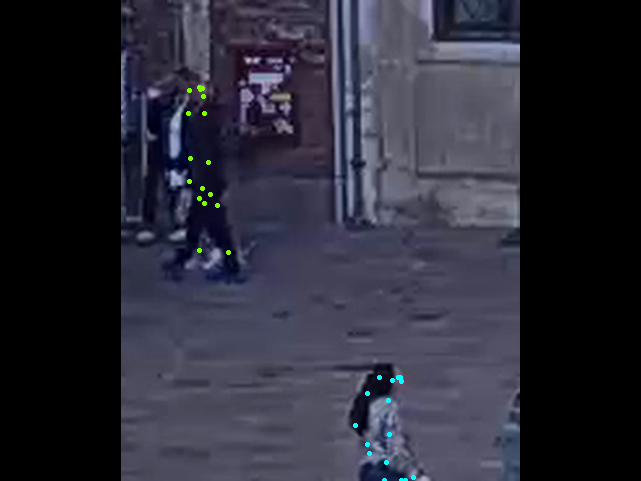

In [61]:
_crop.crop_list.value = 'Pos1'
_app._tab.evaluateWidgetActionList(end=None)['image']

In [ ]:
print_pipeline_info(_app2)

In [63]:
#_crop.add_bookmark('test3')
_crop.remove_bookmark('test3')

CropWidget initMinMax
CropWidget initMinMax


In [65]:
def loadVideo(_app,index):
    
    _keys = list(_video.sources.videos.keys())
    #_video.video_urls.options
    _video.video_urls.value = _keys[index]
    _app._tab.displayWidget.imageselectw.value = str(4)
    _app._tab.displayWidget.imageselectw.value = str(5)
    #print_pipeline_info(_app)

CropWidget initMinMax
CropWidget initMinMax
CropWidget initMinMax
Point(x=215.96646, y=301.76)
Point(x=215.23524, y=297.8247)
Point(x=211.0689, y=297.94095)
Point(x=224.27805, y=297.67236)
Point(x=196.514, y=301.80954)
Point(x=224.44276, y=313.38797)
Point(x=200.56583, y=314.39203)
Point(x=233.15668, y=328.36987)
Point(x=204.7381, y=335.08585)
Point(x=238.2238, y=341.53802)
Point(x=205.16132, y=353.22992)
Point(x=227.52942, y=348.47058)
Point(x=213.74565, y=349.69534)
Point(x=231.09775, y=378.46683)
Point(x=213.45137, y=381.64435)
Point(x=231.89359, y=395.7652)
Point(x=219.3448, y=396.78677)
Point(x=114.76225, y=246.14598)
Point(x=114.87486, y=242.66866)
Point(x=114.23381, y=243.0246)
Point(x=117.10031, y=242.967)
Point(x=114.073074, y=241.85254)
Point(x=121.95485, y=252.54243)
Point(x=117.4902, y=246.2745)
Point(x=124.545456, y=262.90143)
Point(x=112.06829, y=260.76895)
Point(x=120.16671, y=266.07217)
Point(x=116.3552, y=265.3186)
Point(x=120.046295, y=281.0307)
Point(x=118.479515, y=

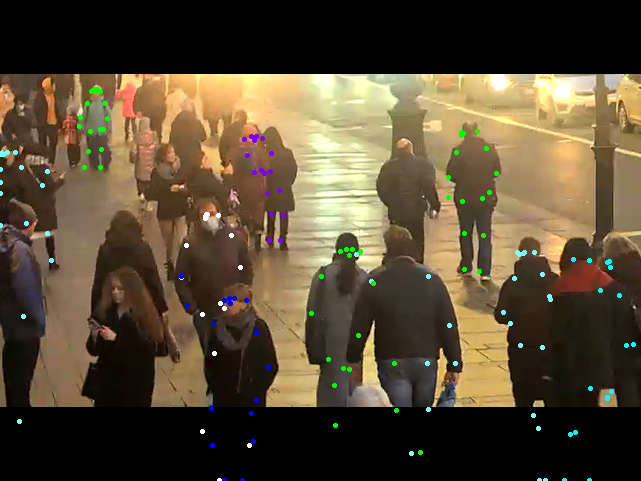

CropWidget initMinMax
CropWidget initMinMax
CropWidget initMinMax
CropWidget initMinMax
CropWidget initMinMax
Point(x=335.13104, y=121.16634)
Point(x=337.17038, y=117.1822)
Point(x=335.54877, y=117.303955)
Point(x=344.81195, y=112.88348)
Point(x=359.03595, y=111.394646)
Point(x=343.3406, y=121.517555)
Point(x=382.46194, y=121.17889)
Point(x=341.04504, y=146.16489)
Point(x=398.02383, y=144.28522)
Point(x=337.55243, y=177.2416)
Point(x=370.7451, y=167.76471)
Point(x=355.36844, y=176.00008)
Point(x=373.82437, y=172.36221)
Point(x=358.18762, y=207.55493)
Point(x=372.3313, y=207.81339)
Point(x=372.78885, y=249.27193)
Point(x=373.90436, y=249.64659)


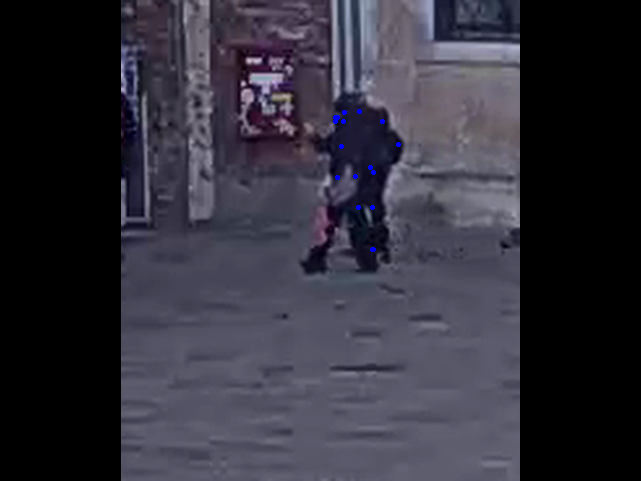

In [72]:
loadVideo(_app,1)
_crop.crop_list.value = 'Position1'
display(_app._tab.evaluateWidgetActionList(end=None)['image'])

loadVideo(_app,0)
_crop.crop_list.value = 'Pos1'
display(_app._tab.evaluateWidgetActionList(end=None)['image'])


Point(x=203.31384, y=160.83563)
Point(x=206.81306, y=157.80145)
Point(x=199.24951, y=157.74626)
Point(x=209.51712, y=160.12723)
Point(x=188.16959, y=159.38509)
Point(x=213.79605, y=175.25993)
Point(x=186.9804, y=177.96078)
Point(x=224.71957, y=197.34479)
Point(x=183.74113, y=205.61781)
Point(x=228.06989, y=213.779)
Point(x=177.04713, y=228.36906)
Point(x=212.10648, y=225.01076)
Point(x=194.1594, y=225.94948)
Point(x=209.61198, y=254.10892)
Point(x=197.87415, y=253.90274)
Point(x=203.30223, y=282.07678)
Point(x=201.33629, y=282.58197)
Point(x=89.07035, y=172.02509)
Point(x=92.34805, y=168.87695)
Point(x=85.374405, y=170.04721)
Point(x=111.60784, y=174.5098)
Point(x=79.77513, y=172.92892)
Point(x=103.83021, y=185.57565)
Point(x=72.98187, y=189.6865)
Point(x=110.21035, y=217.56187)
Point(x=70.54903, y=213.5903)
Point(x=110.97904, y=245.7809)
Point(x=81.165535, y=211.27571)
Point(x=105.347664, y=243.96457)
Point(x=81.534966, y=242.71115)
Point(x=99.35576, y=277.45956)
Point(x=89.03613, y=2

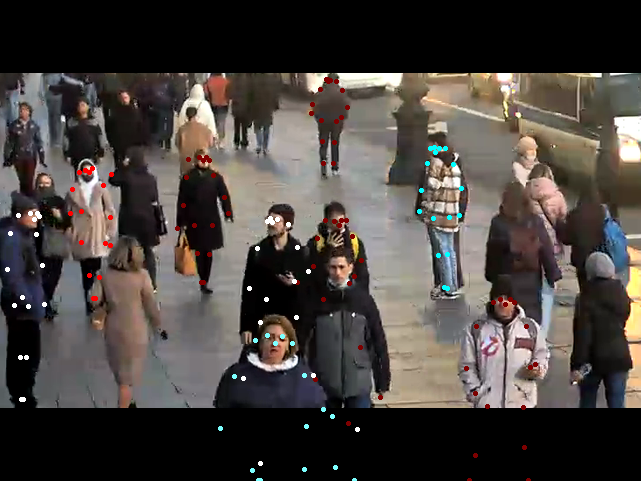

In [68]:
_app._tab.evaluateWidgetActionList(end=None)['image']

# Rest

In [ ]:
_app._tab._widgets[1]._get_VideoAction().sources.videos[_app._tab._widgets[1]._get_VideoAction().id]['bookmarks']

In [ ]:
_app._tab._widgets[4].result

In [ ]:
_app._tab._widgets[3].result['poses'][1].keypoints,_app._tab._widgets[3].result['poses'][1].score


In [ ]:
pose=_app._tab._widgets[3].result['poses'][1]
minimum=[9999999,9999899]
maximum=[0,0]
for label, keypoint in pose.keypoints.items():
                
                print(keypoint.score)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)
                if kp_x<minimum[0]:
                    minimum[0]=kp_x
                if kp_x>maximum[0]:
                    maximum[0]=kp_x
                if kp_y<minimum[1]:
                    minimum[1]=kp_y
                if kp_y>maximum[1]:
                    maximum[1]=kp_y
                
minimum,maximum                

In [ ]:
#def _output_result(update=True, result=None):
#    _app2._tab.displayWidget.update(_app2._tab.displayWidget.action.evaluate())
#_app2._tab._widgets[1].output_result = _output_result   

In [ ]:
def count():    
    counter=0
    for object in _app2._tab._widgets[3].result['objects']:
        if object.id==0:
            counter=counter+1
    return counter
count()


In [ ]:
_app2._tab._widgets[4].result

In [ ]:
print(_app2._tab._widgets[3].result.keys())

# work

In [ ]:
_app._tab._widgets[3].result